In [1]:
import numpy as np   
import matplotlib.pyplot as plt

import emcee
import corner
from chainconsumer import ChainConsumer
from scipy.optimize import minimize

# 1. Preparation

Real value: $A=2.0$, $B=2.0$ $\alpha_B=0.3$

In [2]:

data = np.loadtxt("/home/s/Sijin.Chen/course/from_data_to_insights/tutorial08/xi_measurement_tutorial8.dat")
print(data.shape)
theta = data[:, 0]
xi = data[:, 1]
err = data[:, 2]
err_cov = np.diag(err)

(20, 3)


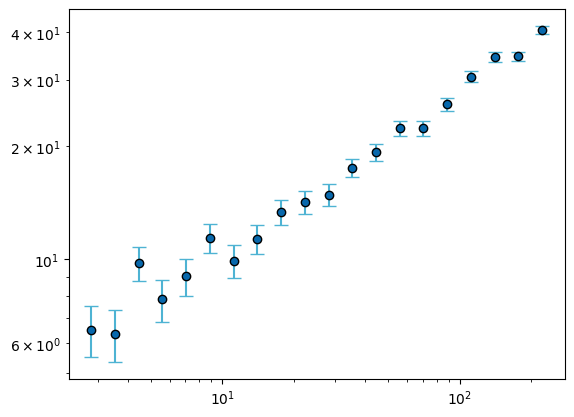

In [3]:
plt.errorbar(theta, xi, yerr=err, fmt='o', mfc='#0868ac', mec='black', ecolor='#4eb3d3', capsize=5)
plt.yscale('log')
plt.xscale("log")

In [4]:
A_s = np.array([2., 2., 3. ])
B_s = np.array([2., 2., 0. ])
alpha_B_s = np.array([0.3, 0.4, 0.3])

In [5]:
def model(theta, A, B, alpha_B):
    return A*theta**0.5 + B * theta**(alpha_B)


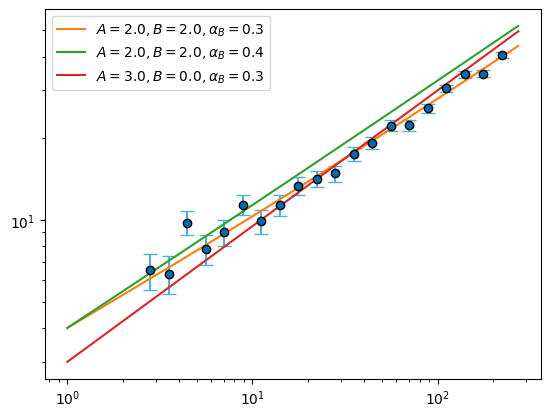

In [6]:
theta_range = np.linspace(1, np.max(theta)+50, 101)

aa = model(theta_range, A_s[0], B_s[0], alpha_B_s[0])

plt.errorbar(theta, xi, yerr=err, fmt='o', mfc='#0868ac', mec='black', ecolor='#4eb3d3', capsize=5)
plt.yscale('log')
plt.xscale("log")

plt.plot(theta_range, model(theta_range, A_s[0], B_s[0], alpha_B_s[0]), label = fr"$A={A_s[0]}, B={B_s[0]}, \alpha_B={alpha_B_s[0]}$")
plt.plot(theta_range, model(theta_range, A_s[1], B_s[1], alpha_B_s[1]), label = fr"$A={A_s[1]}, B={B_s[1]}, \alpha_B={alpha_B_s[1]}$")
plt.plot(theta_range, model(theta_range, A_s[2], B_s[2], alpha_B_s[2]), label = fr"$A={A_s[2]}, B={B_s[2]}, \alpha_B={alpha_B_s[2]}$")

plt.legend()

# 2. Sampling a chain with a nuisance model

In [7]:
def log_prior(params):
    A, B, alpha_B = params
    if -10.0 <= A <= 10.0 and -10.0 <= B <= 10.0 and 0.0 <= alpha_B <=0.4 :
        return 0.0
    return -np.inf


def log_likelihood(params, theta, xi, err_cov):
    A, B, alpha_B = params
    xi_model = A*theta **0.5 + B*theta **alpha_B
    diff = xi_model - xi  
    result = -0.5 * diff.T @ np.linalg.inv(err_cov) @ diff 
    return result


def log_posterior(params, theta, xi, err_cov):
    A, B, alpha_B = params
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, theta, xi, err_cov)

In [8]:
nwalkers = 100
ndim = 3
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))



sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(theta, xi, err_cov)
)
sampler.run_mcmc(initial, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/s/Sijin.Chen/course/from_data_to_insights/tutorial08/venv_corner/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:49<00:00, 100.86it/s]


In [9]:
samples = sampler.get_chain()
print(samples.shape)
flat_samples = sampler.get_chain(discard=4000, flat=True)
print(flat_samples.shape)

(5000, 100, 3)
(100000, 3)


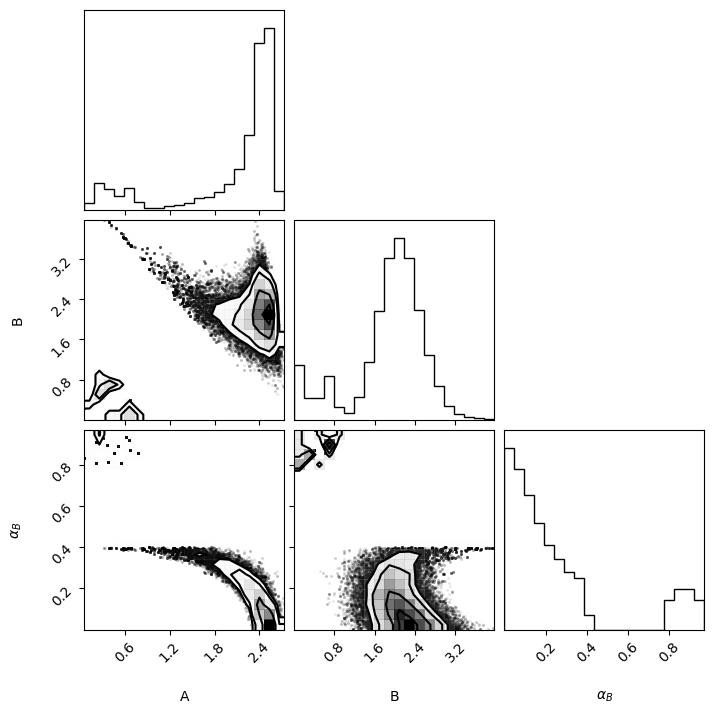

In [10]:

fig = corner.corner(
    flat_samples, labels=["A", "B", r"$\alpha_B$"]
);

In [11]:
def log_prior_wide(params):
    A, B, alpha_B = params
    if -10.0 <= A <= 10.0 and -10.0 <= B <= 10.0 and -2.0 <= alpha_B <=2.0 :
        return 0.0
    return -np.inf


def log_posterior_wide(params, theta, xi, err_cov):
    A, B, alpha_B = params
    lp = log_prior_wide(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, theta, xi, err_cov)





In [12]:
nwalkers = 50
ndim = 3
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))



sampler_wide = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_wide, args=(theta, xi, err_cov)
)
sampler_wide.run_mcmc(initial, 5000, progress=True);

100%|██████████| 5000/5000 [00:32<00:00, 156.03it/s]


In [13]:
samples_wide = sampler_wide.get_chain()
print(samples_wide.shape)
flat_samples_wide = sampler_wide.get_chain(discard=4000, flat=True)
print(flat_samples_wide.shape)

(5000, 50, 3)
(50000, 3)


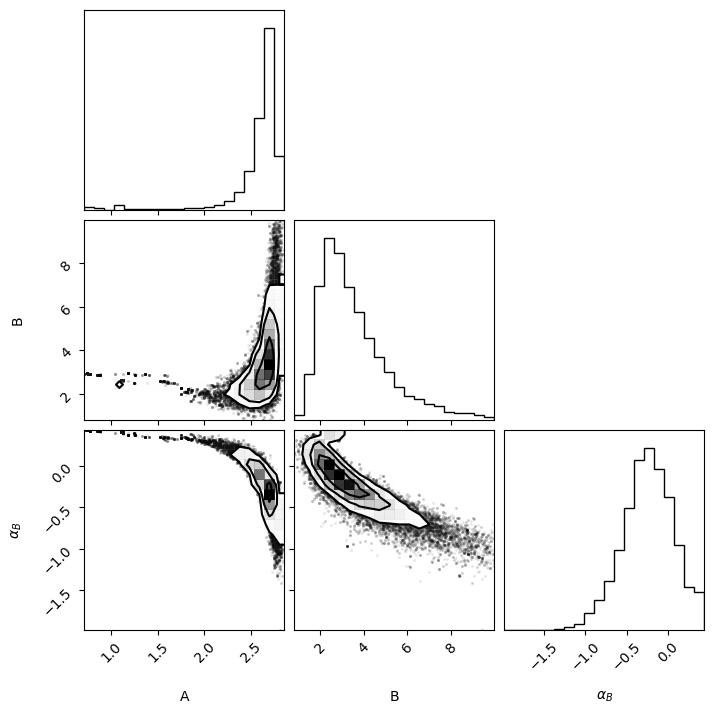

In [14]:
fig = corner.corner(
    flat_samples_wide, labels=["A", "B", r"$\alpha_B$"]
);

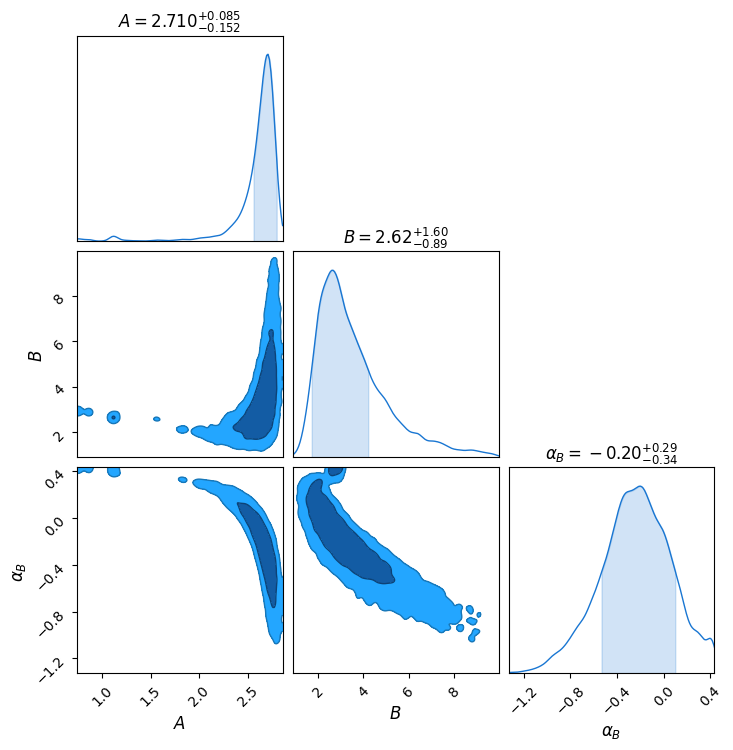

In [15]:
fig = ChainConsumer().add_chain(flat_samples_wide, parameters=['$A$', '$B$', r'$ \alpha_B $']).plotter.plot()

fig.set_size_inches(3 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

# 3. Marginalizing over the nuisance with a covariance

In [16]:
Bsample = np.random.uniform(-10, 10, 10000)
alpha_B_sample = np.random.uniform(0., 0.4, 10000)

nuisance_sample = Bsample * np.power.outer(theta, alpha_B_sample)

print(nuisance_sample.shape)
M = np.cov(nuisance_sample)
print(M.shape)

cov_total = M + err_cov

(20, 10000)
(20, 20)


In [17]:
def model_A(theta, A):
    return A*theta**0.5

In [18]:
def log_prior_A(params):
    A = params
    if -10.0 <= A <= 10.0 :
        return 0.0
    return -np.inf




def log_likelihood_A(params, theta, xi, err_cov):
    A = params
    xi_model = A*theta **0.5
    diff = xi_model - xi  
    result = -0.5 * diff.T @ np.linalg.inv(err_cov) @ diff 
    return result




def log_posterior_A(params, theta, xi, err_cov):
    A = params
    lp = log_prior_A(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_A(params, theta, xi, err_cov)

In [20]:
nwalkers = 100
ndim = 1
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))
print(initial.shape)


sampler_A = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_A, args=(theta, xi, cov_total)
)
sampler_A.run_mcmc(initial, 5000, progress=True);

(100, 1)


100%|██████████| 5000/5000 [00:55<00:00, 89.93it/s] 


(100000, 1)


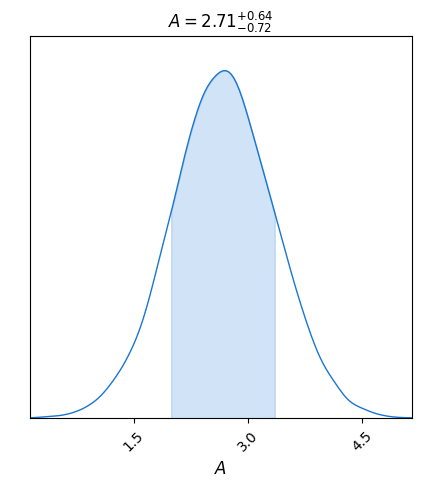

In [21]:
flat_samples_A = sampler_A.get_chain(discard=4000, flat=True)
print(flat_samples_A.shape)

fig = ChainConsumer().add_chain(flat_samples_A, parameters=['$A$']).plotter.plot()

fig.set_size_inches(3 + fig.get_size_inches()) 